# 17. 다음에 볼 영화 예측하기

# ◈ 프로젝트 - Movielens 영화 SBR

이번에도 우리는 Movielens 1M Dataset을 기반으로, Session based Recommendation 시스템을 제작해 보겠습니다.

1) wget으로 데이터 다운로드

$ wget http://files.grouplens.org/datasets/movielens/ml-1m.zip


2) 다운받은 데이터를 작업디렉토리로 이동

$ mv ml-1m.zip ~/aiffel/yoochoose-data


3) 압축 해제

$ cd ~/aiffel/yoochoose-data && unzip ml-1m.zip

## `"ratings.dat"`  format:
### `UserID::MovieID::Rating::Timestamp`



## `"users.dat"`  format:
### `UserID::Gender::Age::Occupation::Zip-code`



## `"movies.dat"` format:
### `MovieID::Title::Genres`


In [1]:
import os
import datetime as tf
from pathlib import Path

import numpy as np
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from datetime import datetime, timedelta
print(datetime.now())

2021-03-19 01:31:55.341515


In [2]:
data_path = Path(os.getenv('HOME')+'/aiffel/yoochoose-data/ml-1m') 
train_path = data_path / 'ratings.dat'

def load_data(data_path: Path, nrows=None):
    data = pd.read_csv(data_path, sep='::', header=None, usecols=[0, 1, 2, 3], dtype={0: np.int32, 1: np.int32, 2: np.int32}, nrows=nrows)
    data.columns = ['UserId', 'ItemId', 'Rating', 'Time']
    return data

data = load_data(train_path, None)
data.sort_values(['UserId', 'Time'], inplace=True)  # data를 id와 시간 순서로 정렬해줍니다.
data

,UserId,ItemId,Rating,Time
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103
...,...,...,...,...
1000019,6040,2917,4,997454429
999988,6040,1921,4,997454464
1000172,6040,1784,3,997454464
1000167,6040,161,3,997454486


- 여기서 이전 실습내역과 가장 크게 다른 부분은 바로 SessionID 대신 UserID 항목이 들어갔다는 점입니다. 이 데이터셋은 명확한 1회 세션의 SessionID를 포함하지 않고 있습니다. 그래서 이번에는 UserID가 SessionID 역할을 해야 합니다.

- Rating 정보가 포함되어 있습니다. 이전 실습내역에서는 이런 항목이 포함되어 있지 않았으므로, 무시하고 제외할 수 있습니다. 하지만, 직전에 봤던 영화가 맘에 들었는지 여부가 비슷한 영화를 더 고르게 하는 것과 상관이 있을 수도 있습니다. 아울러, Rating이 낮은 데이터를 어떻게 처리할지도 고민해야 합니다.

- Time 항목에는 UTC time 가 포함되어, 1970년 1월 1일부터 경과된 초단위 시간이 기재되어 있습니다.

In [3]:
print(data.shape)

(1000209, 4)


In [4]:
data.describe()

,UserId,ItemId,Rating,Time
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09


## Step 1. 데이터의 전처리

위와 같이 간단히 구성해 본 데이터셋을 꼼꼼이 살펴보면서 항목별 기본분석, session length, session time, cleaning 등의 작업을 진행합니다.
특히, 이 데이터셋에서는 Session이 아닌 UserID 단위로 데이터가 생성되어 있으므로, 이를 Session 단위로 어떻게 해석할지에 주의합니다.

In [5]:
data.iloc[0]['Time']

978300019

In [6]:
data.loc[0]

UserId            1
ItemId         1193
Rating            5
Time      978300760
Name: 0, dtype: int64

In [7]:
# 60분 = 60 * 60 = 3600

In [8]:
data['UserId'].nunique(), data['ItemId'].nunique()

(6040, 3706)

In [9]:
userid_length = data.groupby('UserId').size()
userid_length

UserId
1        53
2       129
3        51
4        21
5       198
       ... 
6036    888
6037    202
6038     20
6039    123
6040    341
Length: 6040, dtype: int64

In [10]:
item_length = data.groupby('ItemId').size()
item_length

ItemId
1       2077
2        701
3        478
4        170
5        296
        ... 
3948     862
3949     304
3950      54
3951      40
3952     388
Length: 3706, dtype: int64

In [11]:
#- 사용자가 리뷰를 남기는 횟수를 의미
#- 일반적으로 96~165개의 영화 리뷰
userid_length.median(), userid_length.mean()

(96.0, 165.5975165562914)

In [12]:
# -최소 리뷰, 최대 리뷰
userid_length.min(), userid_length.max()

(20, 2314)

In [13]:
# 99.9% 세션은 길이
userid_length.quantile(0.999)

1343.181000000005

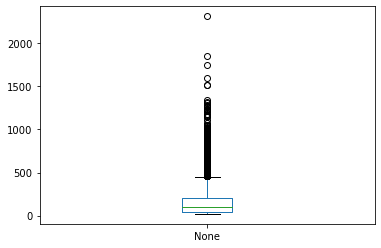

In [14]:
userid_length.plot.box()
plt.show()

In [15]:
#가장긴 리뷰의 데이터 찾기 
long_userid = userid_length[userid_length==2314].index[0]
print("가장 긴 UserId :", long_userid)
data[data['UserId']==long_userid]

가장 긴 UserId : 4169


,UserId,ItemId,Rating,Time
696969,4169,1268,5,965333392
697168,4169,2617,4,965333392
697185,4169,2628,4,965333392
697219,4169,2653,4,965333392
697275,4169,423,3,965333392
...,...,...,...,...
697882,4169,3754,2,1024174347
695702,4169,1413,3,1024175031
697358,4169,494,4,1024175760
695945,4169,1804,2,1024175783


In [16]:
session_id = []

prev_time = 0
prev_user = 0
curr_session = 0

for one_data in data.iloc:
    if one_data['Time'] - prev_time > 3600 or prev_user != one_data['UserId']:
        curr_session += 1
    prev_time = one_data['Time']
    prev_user = one_data['UserId']
    session_id.append(curr_session)
    
data['SessionId'] = session_id

In [17]:
print(data.shape)
data.nunique()

(1000209, 5)


UserId         6040
ItemId         3706
Rating            5
Time         458455
SessionId     24413
dtype: int64

In [18]:
data['DateTime'] = pd.to_datetime(data['Time'], unit='s')

In [19]:
print(data[50:70])

     UserId  ItemId  Rating       Time  SessionId            DateTime
32        1    1566       4  978824330          2 2001-01-06 23:38:50
34        1    1907       4  978824330          2 2001-01-06 23:38:50
25        1      48       5  978824351          2 2001-01-06 23:39:11
130       2    1198       4  978298124          3 2000-12-31 21:28:44
64        2    1210       4  978298151          3 2000-12-31 21:29:11
71        2    1217       3  978298151          3 2000-12-31 21:29:11
134       2    2717       3  978298196          3 2000-12-31 21:29:56
88        2    1293       5  978298261          3 2000-12-31 21:31:01
170       2    2943       4  978298372          3 2000-12-31 21:32:52
106       2    1225       5  978298391          3 2000-12-31 21:33:11
120       2    1193       5  978298413          3 2000-12-31 21:33:33
172       2     318       5  978298413          3 2000-12-31 21:33:33
70        2    3030       4  978298434          3 2000-12-31 21:33:54
105       2    2858 

In [20]:
session_length = data.groupby('SessionId').size()
session_length

SessionId
1         40
2         13
3        129
4         51
5         21
        ... 
24409      7
24410     14
24411      1
24412     21
24413      1
Length: 24413, dtype: int64

In [21]:
session_length.median(), session_length.mean()

(6.0, 40.97034366935649)

In [22]:
session_length.min(), session_length.max()

(1, 1290)

In [23]:
session_length.quantile(0.999)

770.1760000000068

In [24]:
length_count = session_length.groupby(session_length).size()
length_percent_cumsum = length_count.cumsum() / length_count.sum()
length_percent_cumsum_999 = length_percent_cumsum[length_percent_cumsum < 0.999]

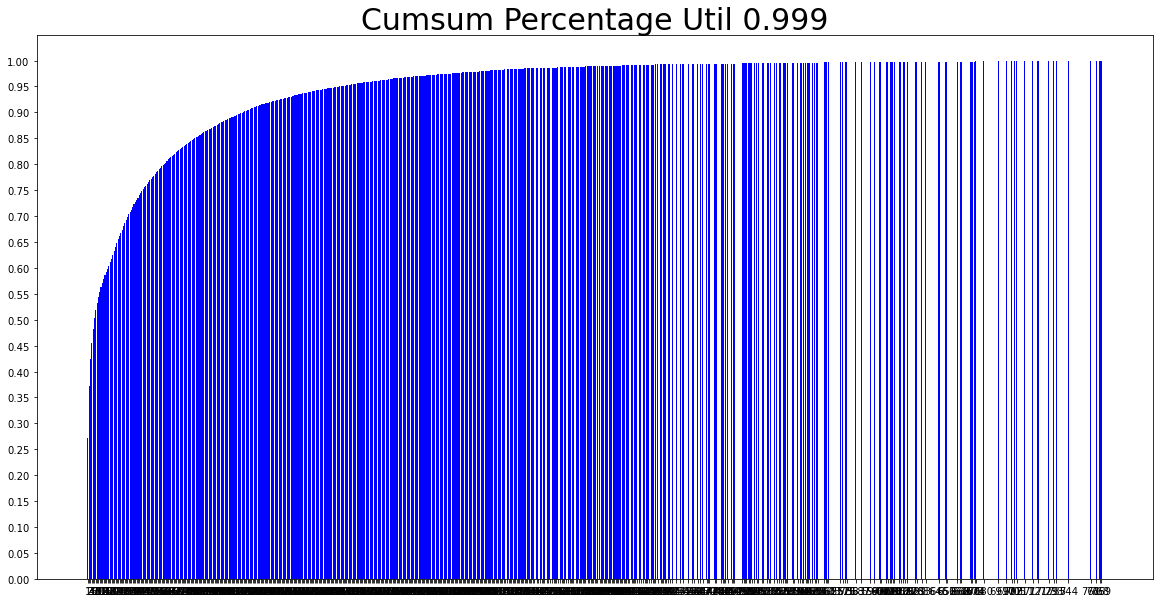

In [25]:
plt.figure(figsize=(20, 10))
plt.bar(x=length_percent_cumsum_999.index,
       height=length_percent_cumsum_999, color='blue')
plt.xticks(length_percent_cumsum_999.index)
plt.yticks(np.arange(0, 1.01, 0.05))
plt.title("Cumsum Percentage Util 0.999", size=20, fontsize=30)
plt.show()

In [26]:
data.isnull().sum()

UserId       0
ItemId       0
Rating       0
Time         0
SessionId    0
DateTime     0
dtype: int64

In [27]:
oldest = data['DateTime'].min()
latest = data['DateTime'].max()
print(oldest)
print(latest)

2000-04-25 23:05:32
2003-02-28 17:49:50


데이터는 3년간의 정보가 들어있습니다. 최근 2년의 데이터만을 사용해볼까요?

In [28]:
month_ago = latest - timedelta(730)
new_data = data[data['DateTime'] > month_ago]
new_data

,UserId,ItemId,Rating,Time,SessionId,DateTime
2327,19,318,4,994556598,43,2001-07-08 01:43:18
2492,19,1234,5,994556636,43,2001-07-08 01:43:56
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51
...,...,...,...,...,...,...
1000019,6040,2917,4,997454429,24412,2001-08-10 14:40:29
999988,6040,1921,4,997454464,24412,2001-08-10 14:41:04
1000172,6040,1784,3,997454464,24412,2001-08-10 14:41:04
1000167,6040,161,3,997454486,24412,2001-08-10 14:41:26


In [29]:
# short_session을 제거한 다음 unpopular item을 제거하면 다시 길이가 1인 session이 생길 수 있습니다.
# 이를 위해 반복문을 통해 지속적으로 제거 합니다.
def cleanse_recursive(data: pd.DataFrame, shortest, least_click) -> pd.DataFrame:
    while True:
        before_len = len(data)
        data = cleanse_short_session(data, shortest)
        #data = cleanse_unpopular_item(data, least_click)
        after_len = len(data)
        if before_len == after_len:
            break
    return data


def cleanse_short_session(data: pd.DataFrame, shortest):
    session_len = data.groupby('SessionId').size()
    session_use = session_len[session_len >= shortest].index
    data = data[data['SessionId'].isin(session_use)]
    return data


def cleanse_unpopular_item(data: pd.DataFrame, least_click):
    item_popular = data.groupby('ItemId').size()
    item_use = item_popular[item_popular >= least_click].index
    data = data[data['ItemId'].isin(item_use)]
    return data

In [30]:
new_data = cleanse_recursive(new_data, shortest=2, least_click=5)
new_data.shape

(65231, 6)

In [31]:
train_ago = latest - timedelta(90)
train = new_data[new_data['DateTime'] < train_ago]

test_ago = latest - timedelta(10)
test = new_data[new_data['DateTime'] > test_ago]

In [32]:
valid_condition = (new_data['DateTime'] > train_ago) & (new_data['DateTime'] < test_ago)
valid = new_data[valid_condition]

In [33]:
print(train.shape)
print("Sessions : ", train['SessionId'].nunique())
print("Items : ", train['ItemId'].nunique())
print("First Time : ", train['DateTime'].min())
print("Last Time : ", train['DateTime'].max())

(60946, 6)
Sessions :  4215
Items :  3271
First Time :  2001-02-28 19:06:53
Last Time :  2002-11-30 13:47:32


In [34]:
print(valid.shape)
print("Sessions : ", valid['SessionId'].nunique())
print("Items : ", valid['ItemId'].nunique())
print("First Time : ", valid['DateTime'].min())
print("Last Time : ", valid['DateTime'].max())

(3812, 6)
Sessions :  299
Items :  1633
First Time :  2002-11-30 21:53:04
Last Time :  2003-02-18 17:36:46


In [35]:
print(test.shape)
print("Sessions : ", test['SessionId'].nunique())
print("Items : ", test['ItemId'].nunique())
print("First Time : ", test['DateTime'].min())
print("Last Time : ", test['DateTime'].max())

(473, 6)
Sessions :  42
Items :  417
First Time :  2003-02-18 19:10:24
Last Time :  2003-02-28 17:49:50


In [36]:
# train set에 없는 아이템이 val, test기간에 생길 수 있으므로 train data를 기준으로 인덱싱합니다.
id2idx = {item_id : index for index, item_id in enumerate(train['ItemId'].unique())}
"""
for index, item_id in enumerate(valid['ItemId'].unique()):
    id2idx[item_id] = index
    
for index, item_id in enumerate(test['ItemId'].unique()):
    id2idx[item_id] = index
"""
def indexing(df, id2idx):
    df['item_idx'] = df['ItemId'].map(lambda x: id2idx.get(x, -1))  # id2idx에 없는 아이템은 모르는 값(-1) 처리 해줍니다.
    return df

In [37]:
train = indexing(train, id2idx)
valid = indexing(valid, id2idx)
test = indexing(test, id2idx)

In [38]:
train

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
2327,19,318,4,994556598,43,2001-07-08 01:43:18,0
2492,19,1234,5,994556636,43,2001-07-08 01:43:56,1
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51,2
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51,3
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51,4
...,...,...,...,...,...,...,...
999923,6040,232,5,997454398,24412,2001-08-10 14:39:58,875
1000019,6040,2917,4,997454429,24412,2001-08-10 14:40:29,1471
999988,6040,1921,4,997454464,24412,2001-08-10 14:41:04,811
1000172,6040,1784,3,997454464,24412,2001-08-10 14:41:04,357


In [39]:
valid

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
5200,36,2269,5,1040544350,86,2002-12-22 08:05:50,1829
5256,36,1701,4,1040544350,86,2002-12-22 08:05:50,1536
5184,36,2694,3,1040544494,86,2002-12-22 08:08:14,570
5364,36,3786,4,1040544521,86,2002-12-22 08:08:41,707
5262,36,2369,4,1040544564,86,2002-12-22 08:09:24,916
...,...,...,...,...,...,...,...
984167,5948,1283,5,1043068249,24102,2003-01-20 13:10:49,109
984206,5948,1304,5,1043068456,24102,2003-01-20 13:14:16,259
984173,5948,1288,4,1043068509,24102,2003-01-20 13:15:09,1016
983996,5948,3467,5,1043068562,24102,2003-01-20 13:16:02,1183


In [40]:
test

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
33889,229,3089,4,1046325739,1028,2003-02-27 06:02:19,1072
33994,229,2839,5,1046325855,1028,2003-02-27 06:04:15,3122
53023,349,163,3,1045946587,1588,2003-02-22 20:43:07,1281
53130,349,1228,4,1045946639,1588,2003-02-22 20:43:59,878
53120,349,548,2,1045946656,1588,2003-02-22 20:44:16,1801
...,...,...,...,...,...,...,...
984731,5950,3948,4,1046369637,24123,2003-02-27 18:13:57,470
984682,5950,3578,4,1046369670,24123,2003-02-27 18:14:30,285
984475,5950,3793,3,1046369710,24123,2003-02-27 18:15:10,284
984660,5950,3555,2,1046369737,24123,2003-02-27 18:15:37,197


In [41]:
save_path = data_path / 'processed2'
save_path.mkdir(parents=True, exist_ok = True)

train.to_pickle(save_path / 'train.pkl')
valid.to_pickle(save_path / 'valid.pkl')
test.to_pickle(save_path / 'test.pkl')

## Step 2. 미니 배치의 구성

실습코드 내역을 참고하여 데이터셋과 미니 배치를 구성해 봅시다. Session-Parallel Mini-Batch의 개념에 따라, 학습 속도의 저하가 최소화될 수 있도록 구성합니다.

In [42]:
class SessionDataset:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, data):
        self.df = data
        self.click_offsets = self.get_click_offsets()
        self.session_idx = np.arange(self.df['SessionId'].nunique())  # indexing to SessionId

    def get_click_offsets(self):
        """
        Return the indexes of the first click of each session IDs,
        """
        offsets = np.zeros(self.df['SessionId'].nunique() + 1, dtype=np.int32)
        offsets[1:] = self.df.groupby('SessionId').size().cumsum()
        return offsets

In [43]:
train_dataset = SessionDataset(train)
train_dataset.df.head(10)

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
2327,19,318,4,994556598,43,2001-07-08 01:43:18,0
2492,19,1234,5,994556636,43,2001-07-08 01:43:56,1
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51,2
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51,3
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51,4
2517,20,2858,4,1009669071,45,2001-12-29 23:37:51,5
2504,20,2641,4,1009669115,45,2001-12-29 23:38:35,6
2510,20,1375,3,1009669115,45,2001-12-29 23:38:35,7
2520,20,3753,5,1009669116,45,2001-12-29 23:38:36,8
2507,20,3527,4,1009669181,45,2001-12-29 23:39:41,9


In [44]:
train_dataset.click_offsets

array([    0,     2,    13, ..., 60915, 60925, 60946], dtype=int32)

In [45]:
train_dataset.session_idx

array([   0,    1,    2, ..., 4212, 4213, 4214])

In [46]:
class SessionDataLoader:
    """Credit to yhs-968/pyGRU4REC."""

    def __init__(self, dataset: SessionDataset, batch_size=16):
        self.dataset = dataset
        self.batch_size = batch_size

    def __iter__(self):
        """ Returns the iterator for producing session-parallel training mini-batches.
        Yields:
            input (B,):  Item indices that will be encoded as one-hot vectors later.
            target (B,): a Variable that stores the target item indices
            masks: Numpy array indicating the positions of the sessions to be terminated
        """

        start, end, mask, last_session, finished = self.initialize()  # initialize 메소드에서 확인해주세요.
        """
        start : Index Where Session Start
        end : Index Where Session End
        mask : indicator for the sessions to be terminated
        """

        while not finished:
            min_len = (end - start).min() - 1  # Shortest Length Among Sessions
            for i in range(min_len):
                # Build inputs & targets
                inp = self.dataset.df['item_idx'].values[start + i]
                target = self.dataset.df['item_idx'].values[start + i + 1]
                yield inp, target, mask

            start, end, mask, last_session, finished = self.update_status(start, end, min_len, last_session, finished)

    def initialize(self):
        first_iters = np.arange(self.batch_size)    # 첫 배치에 사용할 세션 Index를 가져옵니다.
        last_session = self.batch_size - 1    # 마지막으로 다루고 있는 세션 Index를 저장해둡니다.
        start = self.dataset.click_offsets[self.dataset.session_idx[first_iters]]       # data 상에서 session이 시작된 위치를 가져옵니다.
        end = self.dataset.click_offsets[self.dataset.session_idx[first_iters] + 1]  # session이 끝난 위치 바로 다음 위치를 가져옵니다.
        mask = np.array([])   # session의 모든 아이템을 다 돌은 경우 mask에 추가해줄 것입니다.
        finished = False         # data를 전부 돌았는지 기록하기 위한 변수입니다.
        return start, end, mask, last_session, finished

    def update_status(self, start: np.ndarray, end: np.ndarray, min_len: int, last_session: int, finished: bool):  
        # 다음 배치 데이터를 생성하기 위해 상태를 update합니다.
        
        start += min_len   # __iter__에서 min_len 만큼 for문을 돌았으므로 start를 min_len 만큼 더해줍니다.
        mask = np.arange(self.batch_size)[(end - start) == 1]  
        # end는 다음 세션이 시작되는 위치인데 start와 한 칸 차이난다는 것은 session이 끝났다는 뜻입니다. mask에 기록해줍니다.

        for i, idx in enumerate(mask, start=1):  # mask에 추가된 세션 개수만큼 새로운 세션을 돌것입니다.
            new_session = last_session + i  
            if new_session > self.dataset.session_idx[-1]:  # 만약 새로운 세션이 마지막 세션 index보다 크다면 모든 학습데이터를 돈 것입니다.
                finished = True
                break
            # update the next starting/ending point
            start[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session]]     # 종료된 세션 대신 새로운 세션의 시작점을 기록합니다.
            end[idx] = self.dataset.click_offsets[self.dataset.session_idx[new_session] + 1]

        last_session += len(mask)  # 마지막 세션의 위치를 기록해둡니다.
        return start, end, mask, last_session, finished

In [47]:
train_data_loader = SessionDataLoader(train_dataset, batch_size=4)
train_dataset.df.head(15)

,UserId,ItemId,Rating,Time,SessionId,DateTime,item_idx
2327,19,318,4,994556598,43,2001-07-08 01:43:18,0
2492,19,1234,5,994556636,43,2001-07-08 01:43:56,1
2503,20,1694,3,1009669071,45,2001-12-29 23:37:51,2
2512,20,1468,3,1009669071,45,2001-12-29 23:37:51,3
2513,20,3717,2,1009669071,45,2001-12-29 23:37:51,4
2517,20,2858,4,1009669071,45,2001-12-29 23:37:51,5
2504,20,2641,4,1009669115,45,2001-12-29 23:38:35,6
2510,20,1375,3,1009669115,45,2001-12-29 23:38:35,7
2520,20,3753,5,1009669116,45,2001-12-29 23:38:36,8
2507,20,3527,4,1009669181,45,2001-12-29 23:39:41,9


In [48]:
iter_ex = iter(train_data_loader)

In [49]:
inputs, labels, mask =  next(iter_ex)
print(f'Model Input Item Idx are : {inputs}')
print(f'Label Item Idx are : {"":5} {labels}')
print(f'Previous Masked Input Idx are {mask}')

Model Input Item Idx are : [ 0  2 13 23]
Label Item Idx are :       [ 1  3 14 24]
Previous Masked Input Idx are []


## Step 3. 모델 구성

이 부분도 실습코드 내역을 참고하여 다양하게 모델 구조를 시도해볼 수 있습니다.



In [50]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, GRU
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm

In [51]:
def create_model(args):
    inputs = Input(batch_shape=(args.batch_size, 1, args.num_items))
    gru, _ = GRU(args.hsz, stateful=True, return_state=True, name='GRU')(inputs)
    dropout = Dropout(args.drop_rate)(gru)
    predictions = Dense(args.num_items, activation='softmax')(dropout)
    model = Model(inputs=inputs, outputs=[predictions])
    model.compile(loss=categorical_crossentropy, optimizer=Adam(args.lr), metrics=['accuracy'])
    model.summary()
    return model

In [52]:
class Args:
    def __init__(self, tr, val, test, batch_size, hsz, drop_rate, lr, epochs, k):
        self.tr = tr
        self.val = val
        self.test = test
        self.num_items = tr['ItemId'].nunique()
        self.num_sessions = tr['SessionId'].nunique()
        self.batch_size = batch_size
        self.hsz = hsz
        self.drop_rate = drop_rate
        self.lr = lr
        self.epochs = epochs
        self.k = k

args = Args(train, valid, test, batch_size=32, hsz=50, drop_rate=0.1, lr=0.001, epochs=20, k=20)
args1 = Args(train, valid, test, batch_size=64, hsz=60, drop_rate=0.1, lr=0.001, epochs=20, k=20)
args2 = Args(train, valid, test, batch_size=64, hsz=30, drop_rate=0.2, lr=0.001, epochs=20, k=20)
args3 = Args(train, valid, test, batch_size=64, hsz=15, drop_rate=0.1, lr=0.001, epochs=20, k=20)

In [53]:
# 모델 만들기
model = create_model(args)
model1 = create_model(args1)
model2 = create_model(args2)
model3 = create_model(args3)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(32, 1, 3271)]           0         
_________________________________________________________________
GRU (GRU)                    [(32, 50), (32, 50)]      498450    
_________________________________________________________________
dropout (Dropout)            (32, 50)                  0         
_________________________________________________________________
dense (Dense)                (32, 3271)                166821    
Total params: 665,271
Trainable params: 665,271
Non-trainable params: 0
_________________________________________________________________
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(64, 1, 3271)]           0         
______________________________________

## Step 4. 모델 학습

다양한 하이퍼파라미터를 변경해 보며 검증해 보도록 합니다. 실습코드에 언급되었던 Recall, MRR 등의 개념들도 함께 관리될 수 있도록 합니다.



In [54]:
def mrr_k(pred, truth: int, k: int):
    indexing = np.where(pred[:k] == truth)[0]
    if len(indexing) > 0:
        return 1 / (indexing[0] + 1)
    else:
        return 0


def recall_k(pred, truth: int, k: int) -> int:
    answer = truth in pred[:k]
    return int(answer)

In [55]:
# train 셋으로 학습하면서 valid 셋으로 검증합니다.
def train_model(model, args):
    train_dataset = SessionDataset(args.tr)
    train_loader = SessionDataLoader(train_dataset, batch_size=args.batch_size)

    for epoch in range(1, args.epochs + 1):
        total_step = len(args.tr) - args.tr['SessionId'].nunique()
        tr_loader = tqdm(train_loader, total=total_step // args.batch_size, desc='Train', mininterval=1)
        for feat, target, mask in tr_loader:
            reset_hidden_states(model, mask)  # 종료된 session은 hidden_state를 초기화합니다. 아래 메서드에서 확인해주세요.

            input_ohe = to_categorical(feat, num_classes=args.num_items)
            input_ohe = np.expand_dims(input_ohe, axis=1)
            target_ohe = to_categorical(target, num_classes=args.num_items)

            result = model.train_on_batch(input_ohe, target_ohe)
            tr_loader.set_postfix(train_loss=result[0], accuracy = result[1])

        val_recall, val_mrr = get_metrics(args.val, model, args, args.k)  # valid set에 대해 검증합니다.

        print(f"\t - Recall@{args.k} epoch {epoch}: {val_recall:3f}")
        print(f"\t - MRR@{args.k}    epoch {epoch}: {val_mrr:3f}\n")


def reset_hidden_states(model, mask):
    gru_layer = model.get_layer(name='GRU')  # model에서 gru layer를 가져옵니다.
    hidden_states = gru_layer.states[0].numpy()  # gru_layer의 parameter를 가져옵니다.
    for elt in mask:  # mask된 인덱스 즉, 종료된 세션의 인덱스를 돌면서
        hidden_states[elt, :] = 0  # parameter를 초기화 합니다.
    gru_layer.reset_states(states=hidden_states)


def get_metrics(data, model, args, k: int):  # valid셋과 test셋을 평가하는 코드입니다. 
                                             # train과 거의 같지만 mrr, recall을 구하는 라인이 있습니다.
    dataset = SessionDataset(data)
    loader = SessionDataLoader(dataset, batch_size=args.batch_size)
    recall_list, mrr_list = [], []

    total_step = len(data) - data['SessionId'].nunique()
    for inputs, label, mask in tqdm(loader, total=total_step // args.batch_size, desc='Evaluation', mininterval=1):
        reset_hidden_states(model, mask)
        input_ohe = to_categorical(inputs, num_classes=args.num_items)
        input_ohe = np.expand_dims(input_ohe, axis=1)

        pred = model.predict(input_ohe, batch_size=args.batch_size)
        pred_arg = tf.argsort(pred, direction='DESCENDING')  # softmax 값이 큰 순서대로 sorting 합니다.

        length = len(inputs)
        recall_list.extend([recall_k(pred_arg[i], label[i], k) for i in range(length)])
        mrr_list.extend([mrr_k(pred_arg[i], label[i], k) for i in range(length)])

    recall, mrr = np.mean(recall_list), np.mean(mrr_list)
    return recall, mrr

In [56]:
train_model(model, args)

Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=7.64]     

	 - Recall@20 epoch 1: 0.039173
	 - MRR@20    epoch 1: 0.009337



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=7.44]     

	 - Recall@20 epoch 2: 0.054577
	 - MRR@20    epoch 2: 0.012628



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=7.11]

	 - Recall@20 epoch 3: 0.077025
	 - MRR@20    epoch 3: 0.017400



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=6.8]      

	 - Recall@20 epoch 4: 0.089789
	 - MRR@20    epoch 4: 0.022037



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=6.62]     

	 - Recall@20 epoch 5: 0.109595
	 - MRR@20    epoch 5: 0.029603



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.38]

	 - Recall@20 epoch 6: 0.117518
	 - MRR@20    epoch 6: 0.036584



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.25]

	 - Recall@20 epoch 7: 0.126761
	 - MRR@20    epoch 7: 0.039759



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.27]

	 - Recall@20 epoch 8: 0.134243
	 - MRR@20    epoch 8: 0.042281



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.9] 

	 - Recall@20 epoch 9: 0.135123
	 - MRR@20    epoch 9: 0.043273



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.91]

	 - Recall@20 epoch 10: 0.138644
	 - MRR@20    epoch 10: 0.045827



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.52]

	 - Recall@20 epoch 11: 0.141285
	 - MRR@20    epoch 11: 0.044317



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.38]

	 - Recall@20 epoch 12: 0.137764
	 - MRR@20    epoch 12: 0.043924



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.188, train_loss=5.21] 

	 - Recall@20 epoch 13: 0.137764
	 - MRR@20    epoch 13: 0.045047



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0, train_loss=5.17]     

	 - Recall@20 epoch 14: 0.135563
	 - MRR@20    epoch 14: 0.043378



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=5]    

	 - Recall@20 epoch 15: 0.135563
	 - MRR@20    epoch 15: 0.044104



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0938, train_loss=4.98]

	 - Recall@20 epoch 16: 0.133803
	 - MRR@20    epoch 16: 0.044044



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.125, train_loss=4.73] 

	 - Recall@20 epoch 17: 0.132042
	 - MRR@20    epoch 17: 0.043251



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.156, train_loss=4.69] 

	 - Recall@20 epoch 18: 0.131162
	 - MRR@20    epoch 18: 0.041545



Train:   0%|          | 0/1772 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.84]

	 - Recall@20 epoch 19: 0.127641
	 - MRR@20    epoch 19: 0.040175



Evaluation:  65%|██████▌   | 71/109 [00:07<00:04,  9.09it/s]

	 - Recall@20 epoch 20: 0.128081
	 - MRR@20    epoch 20: 0.039383



In [57]:
train_model(model1, args1)

Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.88]     

	 - Recall@20 epoch 1: 0.039714
	 - MRR@20    epoch 1: 0.009542



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.27]

	 - Recall@20 epoch 2: 0.050781
	 - MRR@20    epoch 2: 0.009824



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.12]

	 - Recall@20 epoch 3: 0.059245
	 - MRR@20    epoch 3: 0.014097



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.1]      

	 - Recall@20 epoch 4: 0.081380
	 - MRR@20    epoch 4: 0.018705



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.82]

	 - Recall@20 epoch 5: 0.089193
	 - MRR@20    epoch 5: 0.021745



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.74]

	 - Recall@20 epoch 6: 0.101562
	 - MRR@20    epoch 6: 0.028322



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0469, train_loss=6.66]

	 - Recall@20 epoch 7: 0.113932
	 - MRR@20    epoch 7: 0.031817



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.43]

	 - Recall@20 epoch 8: 0.122396
	 - MRR@20    epoch 8: 0.037027



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.12]

	 - Recall@20 epoch 9: 0.138021
	 - MRR@20    epoch 9: 0.041048



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0625, train_loss=6.17]

	 - Recall@20 epoch 10: 0.140625
	 - MRR@20    epoch 10: 0.041925



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0469, train_loss=5.83]

	 - Recall@20 epoch 11: 0.143229
	 - MRR@20    epoch 11: 0.043527



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=5.47]

	 - Recall@20 epoch 12: 0.142578
	 - MRR@20    epoch 12: 0.043688



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.52]

	 - Recall@20 epoch 13: 0.139323
	 - MRR@20    epoch 13: 0.044166



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0625, train_loss=5.31]

	 - Recall@20 epoch 14: 0.136719
	 - MRR@20    epoch 14: 0.045231



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0781, train_loss=5.47]

	 - Recall@20 epoch 15: 0.139974
	 - MRR@20    epoch 15: 0.045512



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.28]

	 - Recall@20 epoch 16: 0.136068
	 - MRR@20    epoch 16: 0.045593



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.156, train_loss=5.05] 

	 - Recall@20 epoch 17: 0.135417
	 - MRR@20    epoch 17: 0.046086



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0625, train_loss=4.97]

	 - Recall@20 epoch 18: 0.138021
	 - MRR@20    epoch 18: 0.045605



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0938, train_loss=5.07]

	 - Recall@20 epoch 19: 0.136068
	 - MRR@20    epoch 19: 0.044793



Evaluation:  44%|████▍     | 24/54 [00:04<00:05,  5.11it/s]

	 - Recall@20 epoch 20: 0.134766
	 - MRR@20    epoch 20: 0.044569



In [58]:
train_model(model2, args2)

Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.27]     

	 - Recall@20 epoch 1: 0.041667
	 - MRR@20    epoch 1: 0.008460



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.23]     

	 - Recall@20 epoch 2: 0.040365
	 - MRR@20    epoch 2: 0.008676



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.8]      

	 - Recall@20 epoch 3: 0.046224
	 - MRR@20    epoch 3: 0.009728



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.19]     

	 - Recall@20 epoch 4: 0.057943
	 - MRR@20    epoch 4: 0.013294



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.15]

	 - Recall@20 epoch 5: 0.069010
	 - MRR@20    epoch 5: 0.014820



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.06]     

	 - Recall@20 epoch 6: 0.080078
	 - MRR@20    epoch 6: 0.017087



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.89]     

	 - Recall@20 epoch 7: 0.080078
	 - MRR@20    epoch 7: 0.018845



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.01]

	 - Recall@20 epoch 8: 0.082031
	 - MRR@20    epoch 8: 0.019275



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.79]     

	 - Recall@20 epoch 9: 0.086589
	 - MRR@20    epoch 9: 0.020943



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.82]     

	 - Recall@20 epoch 10: 0.091146
	 - MRR@20    epoch 10: 0.022190



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.61]     

	 - Recall@20 epoch 11: 0.104167
	 - MRR@20    epoch 11: 0.024082



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.7] 

	 - Recall@20 epoch 12: 0.111979
	 - MRR@20    epoch 12: 0.027616



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.48]     

	 - Recall@20 epoch 13: 0.115234
	 - MRR@20    epoch 13: 0.029728



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.44]

	 - Recall@20 epoch 14: 0.117188
	 - MRR@20    epoch 14: 0.032115



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.41]

	 - Recall@20 epoch 15: 0.118490
	 - MRR@20    epoch 15: 0.032750



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.3] 

	 - Recall@20 epoch 16: 0.123698
	 - MRR@20    epoch 16: 0.033800



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.32]

	 - Recall@20 epoch 17: 0.120443
	 - MRR@20    epoch 17: 0.036960



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.23]

	 - Recall@20 epoch 18: 0.124349
	 - MRR@20    epoch 18: 0.036598



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=5.92]

	 - Recall@20 epoch 19: 0.125651
	 - MRR@20    epoch 19: 0.035779



Evaluation:  44%|████▍     | 24/54 [00:05<00:06,  4.66it/s]

	 - Recall@20 epoch 20: 0.125651
	 - MRR@20    epoch 20: 0.035604



In [59]:
train_model(model3, args3)

Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.32]     

	 - Recall@20 epoch 1: 0.039714
	 - MRR@20    epoch 1: 0.009256



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.45]

	 - Recall@20 epoch 2: 0.043620
	 - MRR@20    epoch 2: 0.008560



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.36]     

	 - Recall@20 epoch 3: 0.041667
	 - MRR@20    epoch 3: 0.007963



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=7.36]

	 - Recall@20 epoch 4: 0.044922
	 - MRR@20    epoch 4: 0.008940



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.2]      

	 - Recall@20 epoch 5: 0.055339
	 - MRR@20    epoch 5: 0.010219



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.18]     

	 - Recall@20 epoch 6: 0.052734
	 - MRR@20    epoch 6: 0.011159



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.11]     

	 - Recall@20 epoch 7: 0.057943
	 - MRR@20    epoch 7: 0.011600



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.65]     

	 - Recall@20 epoch 8: 0.063151
	 - MRR@20    epoch 8: 0.013519



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7]        

	 - Recall@20 epoch 9: 0.064453
	 - MRR@20    epoch 9: 0.013334



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.96]

	 - Recall@20 epoch 10: 0.063802
	 - MRR@20    epoch 10: 0.014341



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.87]

	 - Recall@20 epoch 11: 0.070964
	 - MRR@20    epoch 11: 0.016551



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.87]

	 - Recall@20 epoch 12: 0.076823
	 - MRR@20    epoch 12: 0.017940



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.67]     

	 - Recall@20 epoch 13: 0.077474
	 - MRR@20    epoch 13: 0.020532



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7.04]     

	 - Recall@20 epoch 14: 0.083984
	 - MRR@20    epoch 14: 0.021571



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=7]        

	 - Recall@20 epoch 15: 0.087891
	 - MRR@20    epoch 15: 0.022839



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.71]

	 - Recall@20 epoch 16: 0.095703
	 - MRR@20    epoch 16: 0.025930



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0156, train_loss=6.7] 

	 - Recall@20 epoch 17: 0.096354
	 - MRR@20    epoch 17: 0.027145



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0, train_loss=6.79]     

	 - Recall@20 epoch 18: 0.100260
	 - MRR@20    epoch 18: 0.026933



Train:   0%|          | 0/886 [00:00<?, ?it/s, accuracy=0.0312, train_loss=6.64]

	 - Recall@20 epoch 19: 0.104818
	 - MRR@20    epoch 19: 0.029008



Evaluation:  44%|████▍     | 24/54 [00:04<00:06,  4.90it/s]

	 - Recall@20 epoch 20: 0.105469
	 - MRR@20    epoch 20: 0.030610



## Step 5. 모델 테스트

미리 구성한 테스트셋을 바탕으로 Recall, MRR 을 확인해 봅니다.

In [60]:
def test_model(model, args, test):
    test_recall, test_mrr = get_metrics(test, model, args, 20)
    print(f"\t - Recall@{args.k}: {test_recall:3f}")
    print(f"\t - MRR@{args.k}: {test_mrr:3f}\n")

In [61]:
test_model(model, args, test)

Evaluation:  15%|█▌        | 2/13 [00:00<00:01,  8.61it/s]

	 - Recall@20: 0.093750
	 - MRR@20: 0.025279



# ◈ 루브릭


평가문항/상세기준

1. Movielens 데이터셋을 session based recommendation 관점으로 전처리하는 과정이 체계적으로 진행되었다.  
데이터셋의 면밀한 분석을 토대로 세션단위 정의 과정(길이분석, 시간분석)을 합리적으로 수행한 과정이 기술되었다.

 
2. RNN 기반의 예측 모델이 정상적으로 구성되어 안정적으로 훈련이 진행되었다.  
적절한 epoch만큼의 학습이 진행되는 과정에서 train loss가 안정적으로 감소하고, validation 단계에서의 Recall, MRR이 개선되는 것이 확인된다.


3. 세션정의, 모델구조, 하이퍼파라미터 등을 변경해서 실험하여 Recall, MRR 등의 변화추이를 관찰하였다.  
3가지 이상의 변화를 시도하고 그 실험결과를 체계적으로 분석하였다.


# 회고
- 이번 프로젝트에서 **어려웠던 점,**
- 프로젝트를 진행하면서 **알아낸 점** 혹은 **아직 모호한 점**.
- 루브릭 평가 지표를 맞추기 위해 **시도한 것들**.
- 만약에 루브릭 평가 관련 지표를 **달성 하지 못했을 때, 이유에 관한 추정**.
- **자기 다짐**


***
***

# ◈ 결과 및 고찰

### *  어려운 점 및 해결 방법
학습은 되었지만 모델테스트에서 제대로 된 결과가 나오질 않았다. 추후에 오류가 있는 부분을 다시 점점해 보니, 학습데이터를 나누는 과정에서 날짜로 계산하여 train, validate, test 데이터를 잘못 다루어서 문제가 생긴 것이었다.
잘 학습되는 다른 방법을 찾아서 해결하였으나, 이후에도 같은 문제가 생겨도 정확한 원인을 파악하기 어려울 것으로 생각되었다. 
좀더 기본적인 코드의 이해과정이 필요하지 않을까 생각되었다. 

